In [35]:
import pandas as pd

# Load the CSV files
krw_btc_df = pd.read_csv('KRW-BTC_1min_data_last_8_days_Sep28.csv')
krw_usdt_df = pd.read_csv('KRW-USDT_1min_data_last_8_days_Sep28.csv')
binance_btcusdt_df = pd.read_csv('binance_btcusdt_full.csv')
ohlcv_filled_df = pd.read_csv('ohlcv_filled_24h.csv')

# Convert timestamp columns to datetime
krw_btc_df['candle_date_time_kst'] = pd.to_datetime(krw_btc_df['candle_date_time_kst'])
krw_usdt_df['candle_date_time_kst'] = pd.to_datetime(krw_usdt_df['candle_date_time_kst'])
ohlcv_filled_df['DateTime'] = pd.to_datetime(ohlcv_filled_df['Date'] + ' ' + ohlcv_filled_df['Time'])
binance_btcusdt_df['timestamp'] = pd.to_datetime(binance_btcusdt_df['timestamp'])

# Convert KST to UTC (Binance data is already in UTC)
krw_btc_df['candle_date_time_utc'] = krw_btc_df['candle_date_time_kst'].dt.tz_localize('Asia/Seoul').dt.tz_convert('UTC')
krw_usdt_df['candle_date_time_utc'] = krw_usdt_df['candle_date_time_kst'].dt.tz_localize('Asia/Seoul').dt.tz_convert('UTC')
ohlcv_filled_df['DateTime_utc'] = ohlcv_filled_df['DateTime'].dt.tz_localize('Asia/Seoul').dt.tz_convert('UTC')
binance_btcusdt_df['timestamp'] = binance_btcusdt_df['timestamp'].dt.tz_localize('UTC')  # Binance already in UTC

# Sort the data by the UTC timestamps
krw_btc_df = krw_btc_df.sort_values(by='candle_date_time_utc')
krw_usdt_df = krw_usdt_df.sort_values(by='candle_date_time_utc')
ohlcv_filled_df = ohlcv_filled_df.sort_values(by='DateTime_utc')
binance_btcusdt_df = binance_btcusdt_df.sort_values(by='timestamp')

# Display the first few rows to confirm correct loading and timezone conversion
print("KRW-BTC:\n", krw_btc_df.head())
print("KRW-USDT:\n", krw_usdt_df.head())
print("OHLCV Filled:\n", ohlcv_filled_df.head())
print("Binance BTC/USDT:\n", binance_btcusdt_df.head())

KRW-BTC:
         market      candle_date_time_utc candle_date_time_kst  opening_price   
14599  KRW-BTC 2024-09-18 03:19:00+00:00  2024-09-18 12:19:00     81399000.0  \
14598  KRW-BTC 2024-09-18 03:20:00+00:00  2024-09-18 12:20:00     81290000.0   
14597  KRW-BTC 2024-09-18 03:21:00+00:00  2024-09-18 12:21:00     81310000.0   
14596  KRW-BTC 2024-09-18 03:22:00+00:00  2024-09-18 12:22:00     81367000.0   
14595  KRW-BTC 2024-09-18 03:23:00+00:00  2024-09-18 12:23:00     81367000.0   

       high_price   low_price  trade_price      timestamp   
14599  81399000.0  81280000.0   81300000.0  1726629600030  \
14598  81325000.0  81280000.0   81310000.0  1726629659580   
14597  81378000.0  81300000.0   81316000.0  1726629718344   
14596  81377000.0  81316000.0   81321000.0  1726629778276   
14595  81367000.0  81321000.0   81364000.0  1726629839750   

       candle_acc_trade_price  candle_acc_trade_volume  unit  
14599            3.244912e+08                 3.988832     1  
14598           

In [36]:
# Merge the data on the closest matching timestamps using the UTC datetime columns

# Merge KRW-BTC with OHLCV data (based on their UTC timestamps)
merged_df = pd.merge_asof(
    ohlcv_filled_df[['DateTime_utc', 'Close']], 
    krw_btc_df[['candle_date_time_utc', 'trade_price']], 
    left_on='DateTime_utc', 
    right_on='candle_date_time_utc', 
    direction='backward'
)

# Merge with KRW-USDT
merged_df = pd.merge_asof(
    merged_df, 
    krw_usdt_df[['candle_date_time_utc', 'trade_price']], 
    left_on='DateTime_utc', 
    right_on='candle_date_time_utc', 
    suffixes=('_btc', '_usdt'),
    direction='backward'
)

# Merge with Binance BTC/USDT data
merged_df = pd.merge_asof(
    merged_df, 
    binance_btcusdt_df[['timestamp', 'Close']], 
    left_on='DateTime_utc', 
    right_on='timestamp', 
    suffixes=('', '_binance'),
    direction='backward'
)

# Rename columns for clarity
merged_df.rename(columns={
    'Close': 'Close_ohlcv',
    'trade_price_btc': 'KRW_BTC',
    'trade_price_usdt': 'KRW_USDT',
    'Close_binance': 'Binance_BTCUSDT'
}, inplace=True)

# Display the first few rows of the merged dataframe
print(merged_df.head())

               DateTime_utc  Close_ohlcv  candle_date_time_utc_btc   
0 2024-09-23 00:00:00+00:00       1331.2 2024-09-23 00:00:00+00:00  \
1 2024-09-23 00:01:00+00:00       1331.4 2024-09-23 00:01:00+00:00   
2 2024-09-23 00:02:00+00:00       1331.4 2024-09-23 00:02:00+00:00   
3 2024-09-23 00:03:00+00:00       1330.9 2024-09-23 00:03:00+00:00   
4 2024-09-23 00:04:00+00:00       1331.9 2024-09-23 00:04:00+00:00   

      KRW_BTC candle_date_time_utc_usdt  KRW_USDT                 timestamp   
0  84899000.0 2024-09-23 00:00:00+00:00    1336.0 2024-09-23 00:00:00+00:00  \
1  84887000.0 2024-09-23 00:01:00+00:00    1336.0 2024-09-23 00:01:00+00:00   
2  84809000.0 2024-09-23 00:02:00+00:00    1336.0 2024-09-23 00:02:00+00:00   
3  84771000.0 2024-09-23 00:03:00+00:00    1336.0 2024-09-23 00:03:00+00:00   
4  84770000.0 2024-09-23 00:04:00+00:00    1336.0 2024-09-23 00:04:00+00:00   

   Binance_BTCUSDT  
0         63552.00  
1         63546.97  
2         63493.99  
3         63455.58  

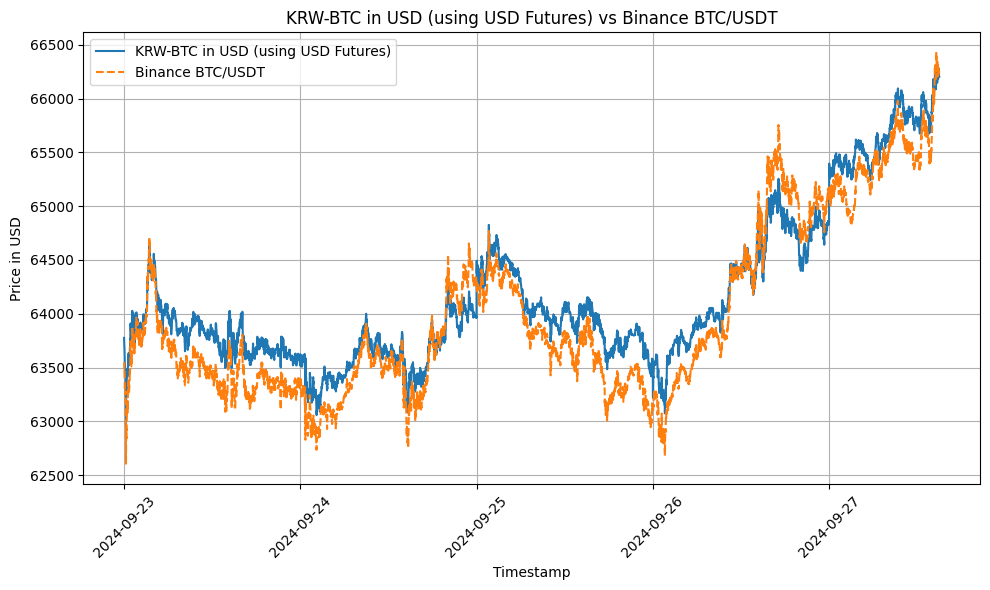

In [37]:
import matplotlib.pyplot as plt

# Calculate KRW-BTC price in USD using the USD futures close price
merged_df['KRW_BTC_in_USD'] = merged_df['KRW_BTC'] / merged_df['Close_ohlcv']

# Plot KRW-BTC in USD vs Binance BTC/USDT
plt.figure(figsize=(10, 6))
plt.plot(merged_df['DateTime_utc'], merged_df['KRW_BTC_in_USD'], label='KRW-BTC in USD (using USD Futures)')
plt.plot(merged_df['DateTime_utc'], merged_df['Binance_BTCUSDT'], label='Binance BTC/USDT', linestyle='--')

plt.title('KRW-BTC in USD (using USD Futures) vs Binance BTC/USDT')
plt.xlabel('Timestamp')
plt.ylabel('Price in USD')
plt.xticks(rotation=45)  # Rotate timestamps for readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

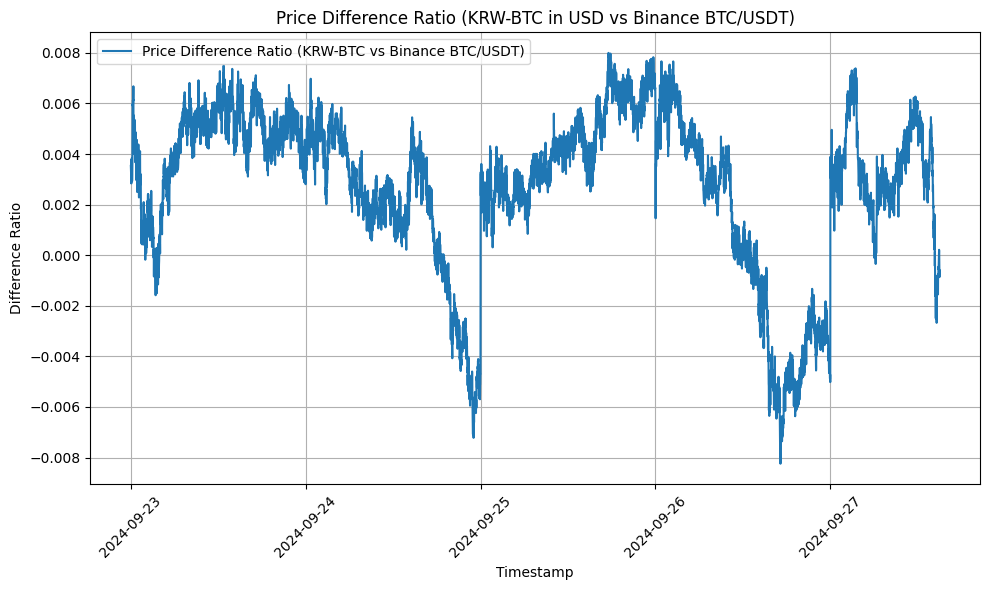

In [38]:
# Calculate the price difference ratio: (KRW-BTC in USD - Binance BTC/USDT) / Binance BTC/USDT
merged_df['price_diff_ratio'] = (merged_df['KRW_BTC_in_USD'] - merged_df['Binance_BTCUSDT']) / merged_df['Binance_BTCUSDT']

# Plot the price difference ratio
plt.figure(figsize=(10, 6))
plt.plot(merged_df['DateTime_utc'], merged_df['price_diff_ratio'], label='Price Difference Ratio (KRW-BTC vs Binance BTC/USDT)')

plt.title('Price Difference Ratio (KRW-BTC in USD vs Binance BTC/USDT)')
plt.xlabel('Timestamp')
plt.ylabel('Difference Ratio')
plt.xticks(rotation=45)  # Rotate timestamps for readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

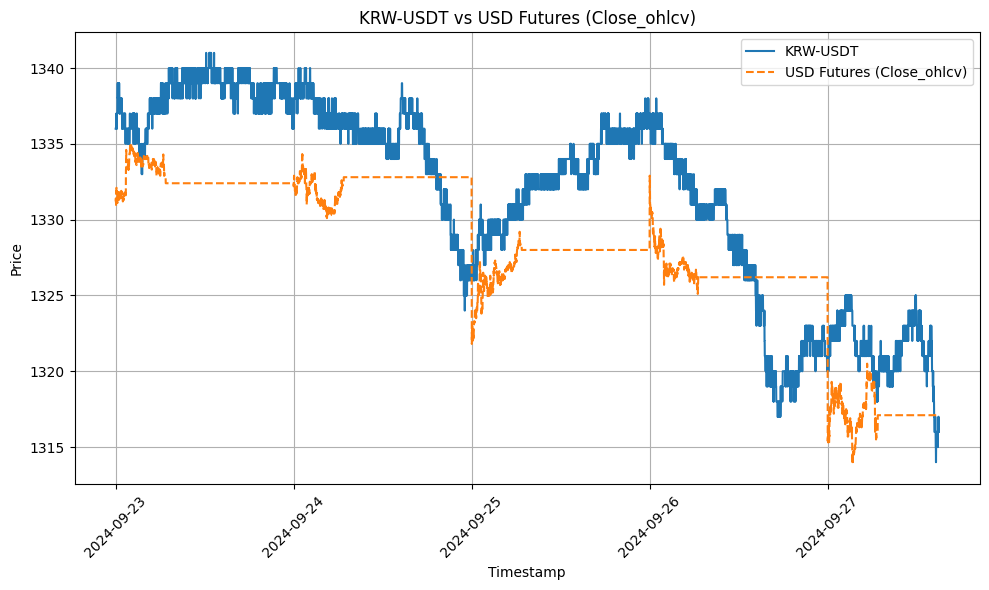

In [39]:
import matplotlib.pyplot as plt

# Plot KRW-USDT vs USD futures (Close_ohlcv)
plt.figure(figsize=(10, 6))
plt.plot(merged_df['DateTime_utc'], merged_df['KRW_USDT'], label='KRW-USDT')
plt.plot(merged_df['DateTime_utc'], merged_df['Close_ohlcv'], label='USD Futures (Close_ohlcv)', linestyle='--')

plt.title('KRW-USDT vs USD Futures (Close_ohlcv)')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate timestamps for readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

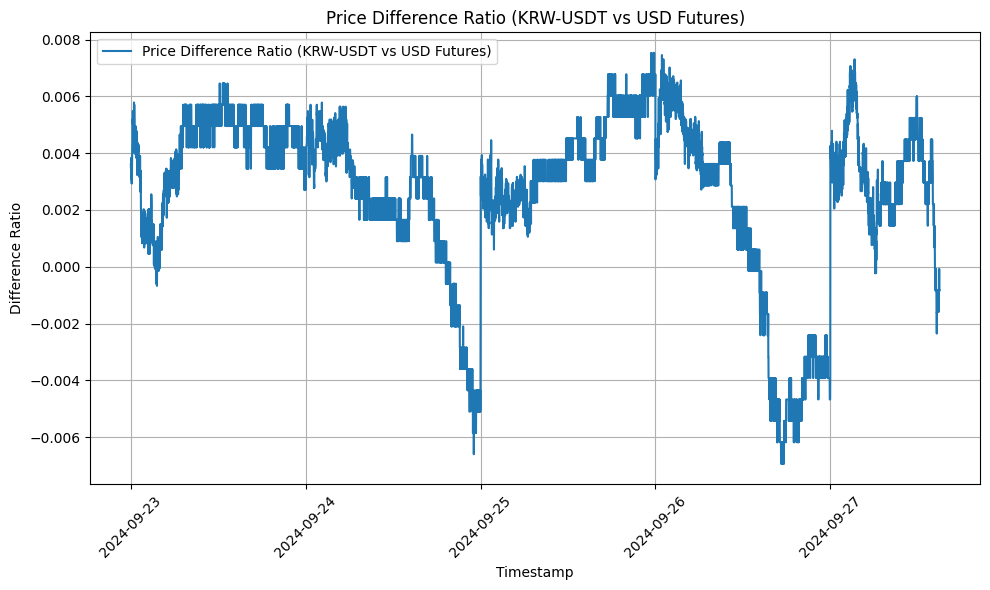

In [40]:
# Calculate the price difference ratio: (KRW-USDT - USD Futures) / USD Futures
merged_df['usdt_diff_ratio'] = (merged_df['KRW_USDT'] - merged_df['Close_ohlcv']) / merged_df['Close_ohlcv']

# Plot the price difference ratio
plt.figure(figsize=(10, 6))
plt.plot(merged_df['DateTime_utc'], merged_df['usdt_diff_ratio'], label='Price Difference Ratio (KRW-USDT vs USD Futures)')

plt.title('Price Difference Ratio (KRW-USDT vs USD Futures)')
plt.xlabel('Timestamp')
plt.ylabel('Difference Ratio')
plt.xticks(rotation=45)  # Rotate timestamps for readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()